# Curate Cao 2020 - human fetal pancreatic cells

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
os.environ['R_HOME'] = './code/miniconda3/envs//r_env/lib/R'
import anndata2ri
import matplotlib.pyplot as pl
import seaborn as sns
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()

# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

In [84]:
#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Load data

data downloaded from https://descartes.brotmanbaty.org/bbi/human-gene-expression-during-development/

In [109]:
%%R -o sce
library(SingleCellExperiment)
df = readRDS('./data/Pancreas_gene_count.RDS', refhook = NULL)
sce <- SingleCellExperiment(list(counts = df))

In [110]:
# map ensembl IDs to ensembl gene names using CellRanger output file
var_dict = pd.read_csv('./data/features.txt')

In [ ]:
var_dict.columns = ['ens_id', 'ens_gene']

In [111]:
var_list = sce.var_names.tolist()
for i,var in enumerate(sce.var_names):
    var_ens = var.split('.')[0]
    var_symbol = var_dict.loc[var_dict.ens_id==var_ens, 'ens_gene'].values.tolist()
    if len(var_symbol)>0:
        var_list[i]=var_symbol[0]

In [112]:
sce.var_names = pd.Index(var_list)

### Preprocessing

In [113]:
sc.pp.filter_genes(sce, min_cells=10)

/Users/stritschler/code/miniconda3/envs/r_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [114]:
sc.pp.filter_cells(sce, min_counts=1000)

/Users/stritschler/code/miniconda3/envs/r_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [116]:
sc.pp.normalize_total(sce, exclude_highly_expressed=True)

/Users/stritschler/code/miniconda3/envs/r_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [117]:
sc.pp.log1p(sce)

### Manifold all cells

In [118]:
sc.pp.highly_variable_genes(sce, n_top_genes=4000)

In [119]:
sc.pp.pca(sce)
sc.pp.neighbors(sce)
sc.tl.umap(sce)

/Users/stritschler/code/miniconda3/envs/r_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [124]:
sc.set_figure_params(frameon=False)

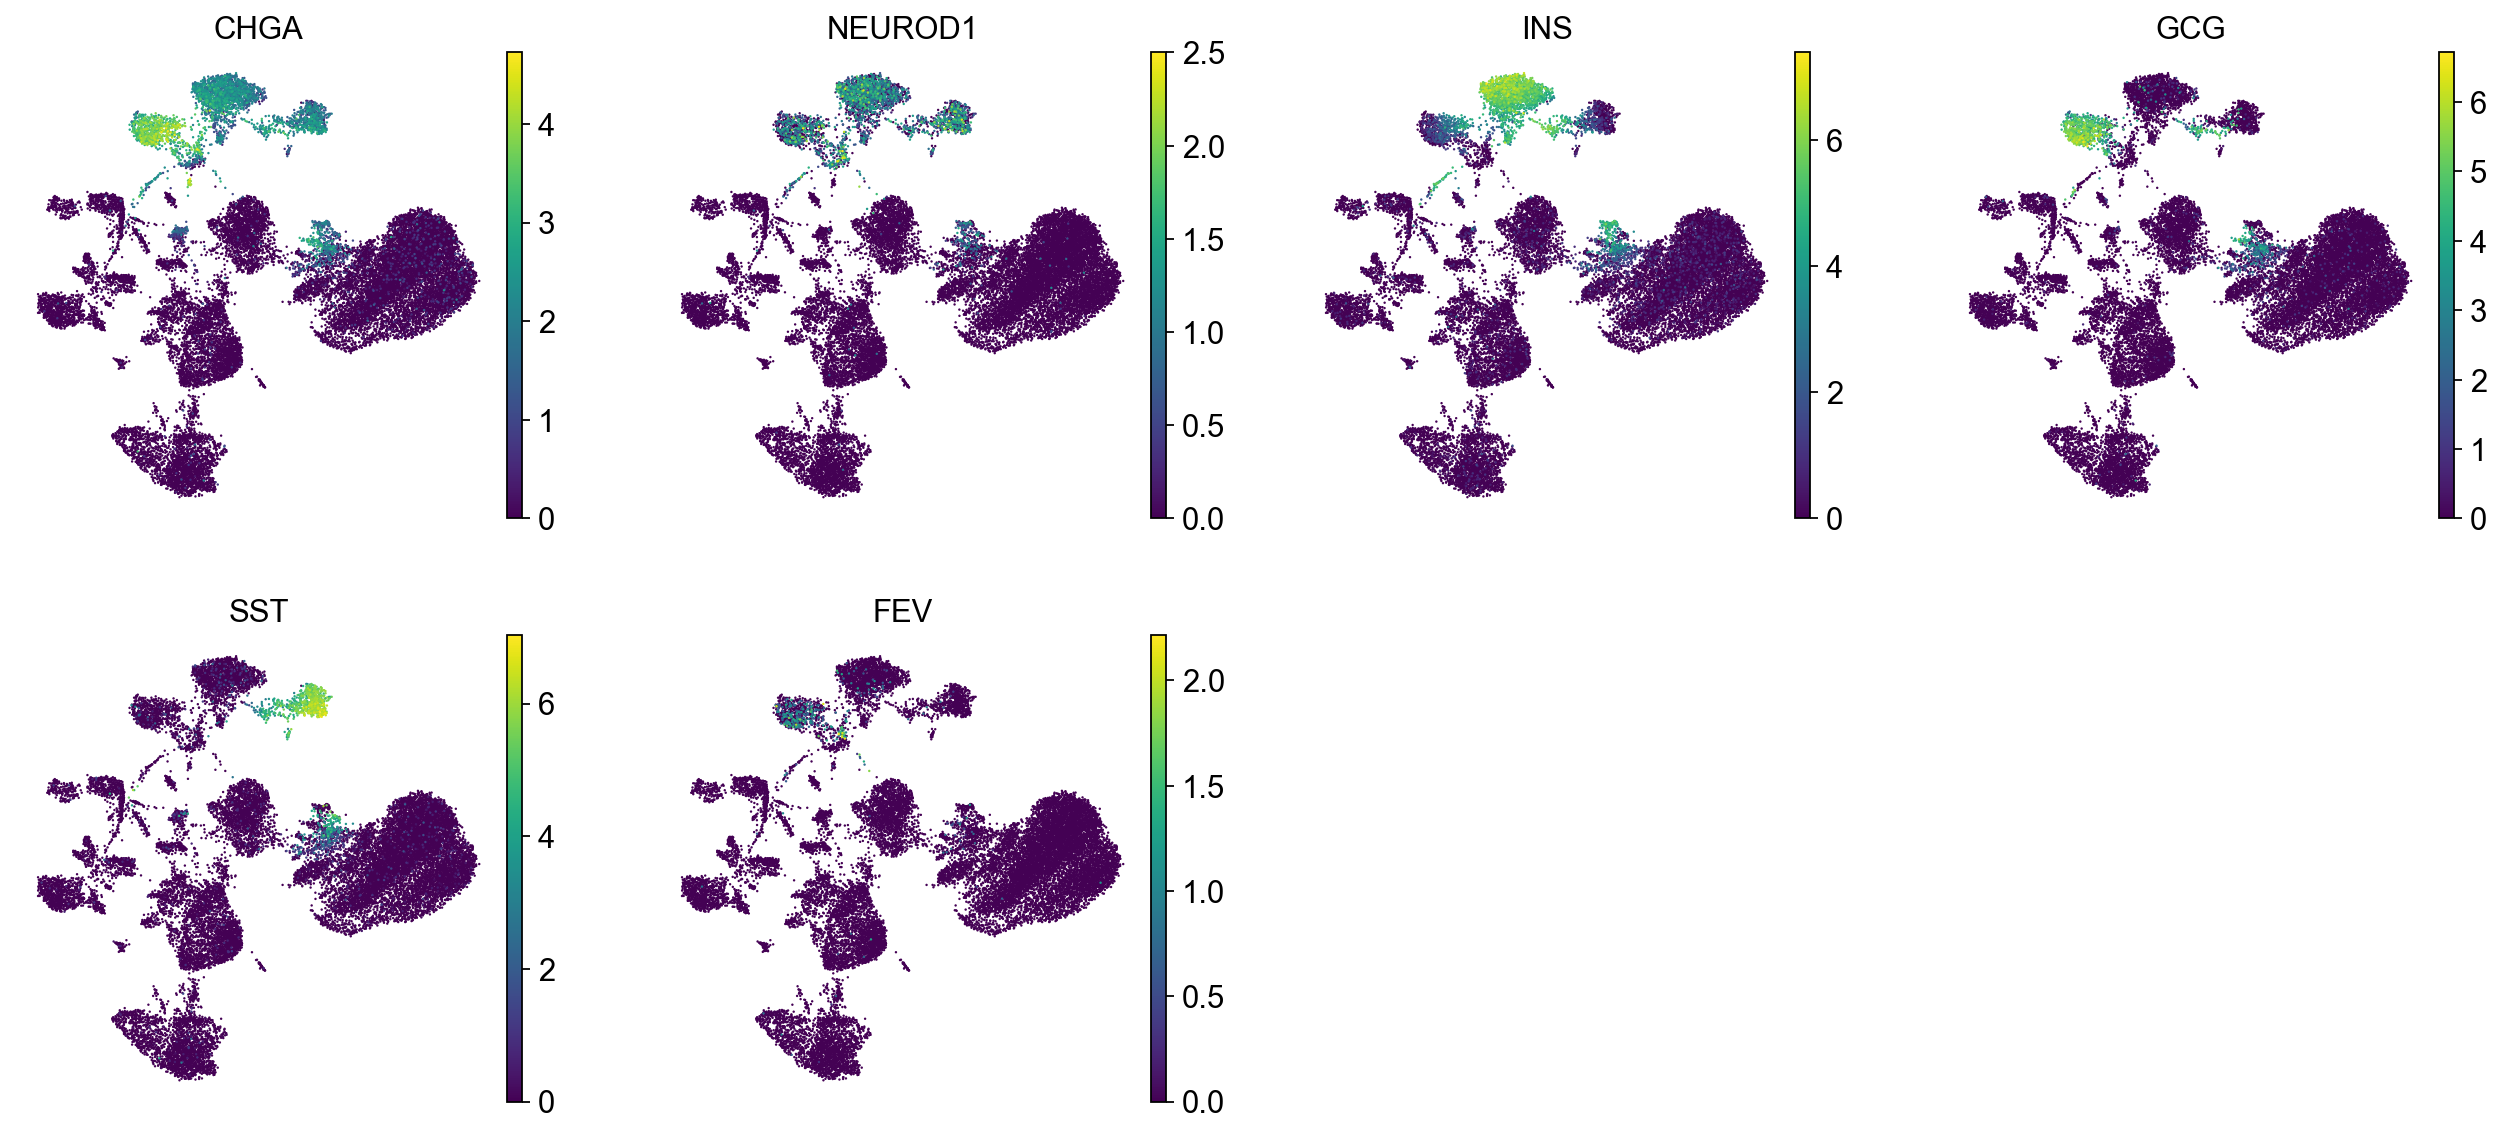

In [125]:
sc.pl.umap(sce, color=['CHGA', 'NEUROD1', 'INS', 'GCG', 'SST', 'FEV'])

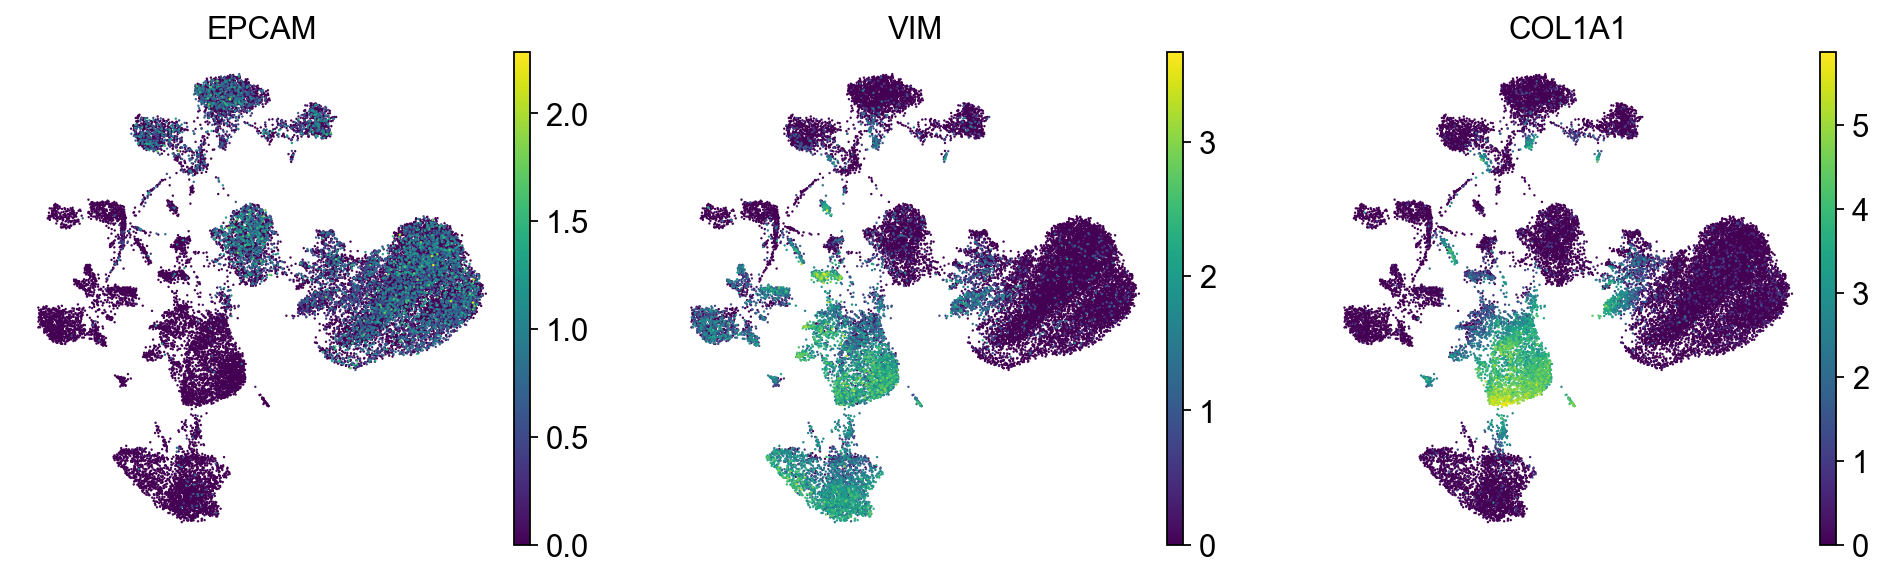

In [166]:
sc.pl.umap(sce, color=['EPCAM', 'VIM', 'COL1A1'])

In [126]:
sc.tl.louvain(sce)

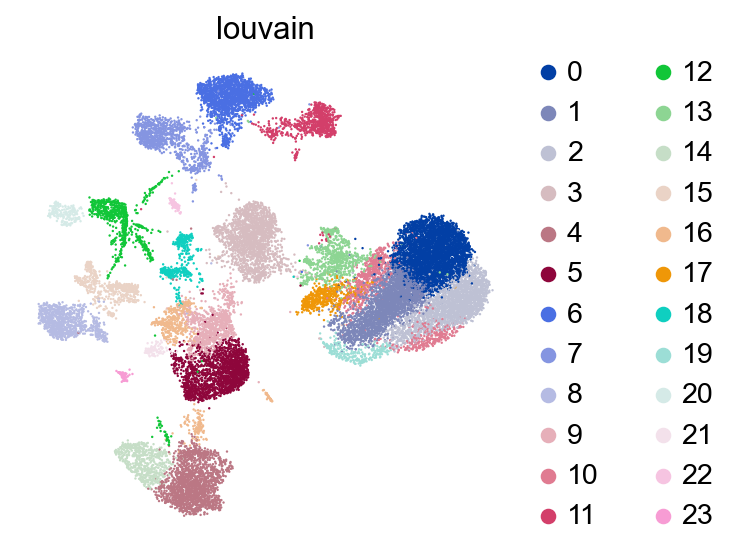

In [129]:
sc.pl.umap(sce, color='louvain')

### Manifold and clustering endocrine cells

In [130]:
sce_endo = sce[sce.obs.louvain.isin(['7', '6', '11'])].copy()

/Users/stritschler/code/miniconda3/envs/r_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [131]:
sc.pp.filter_genes(sce_endo, min_cells=10)

/Users/stritschler/code/miniconda3/envs/r_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [133]:
sc.pp.highly_variable_genes(sce_endo, n_top_genes=4000)
sc.pp.pca(sce_endo)
sc.pp.neighbors(sce_endo)
sc.tl.umap(sce_endo)

/Users/stritschler/code/miniconda3/envs/r_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


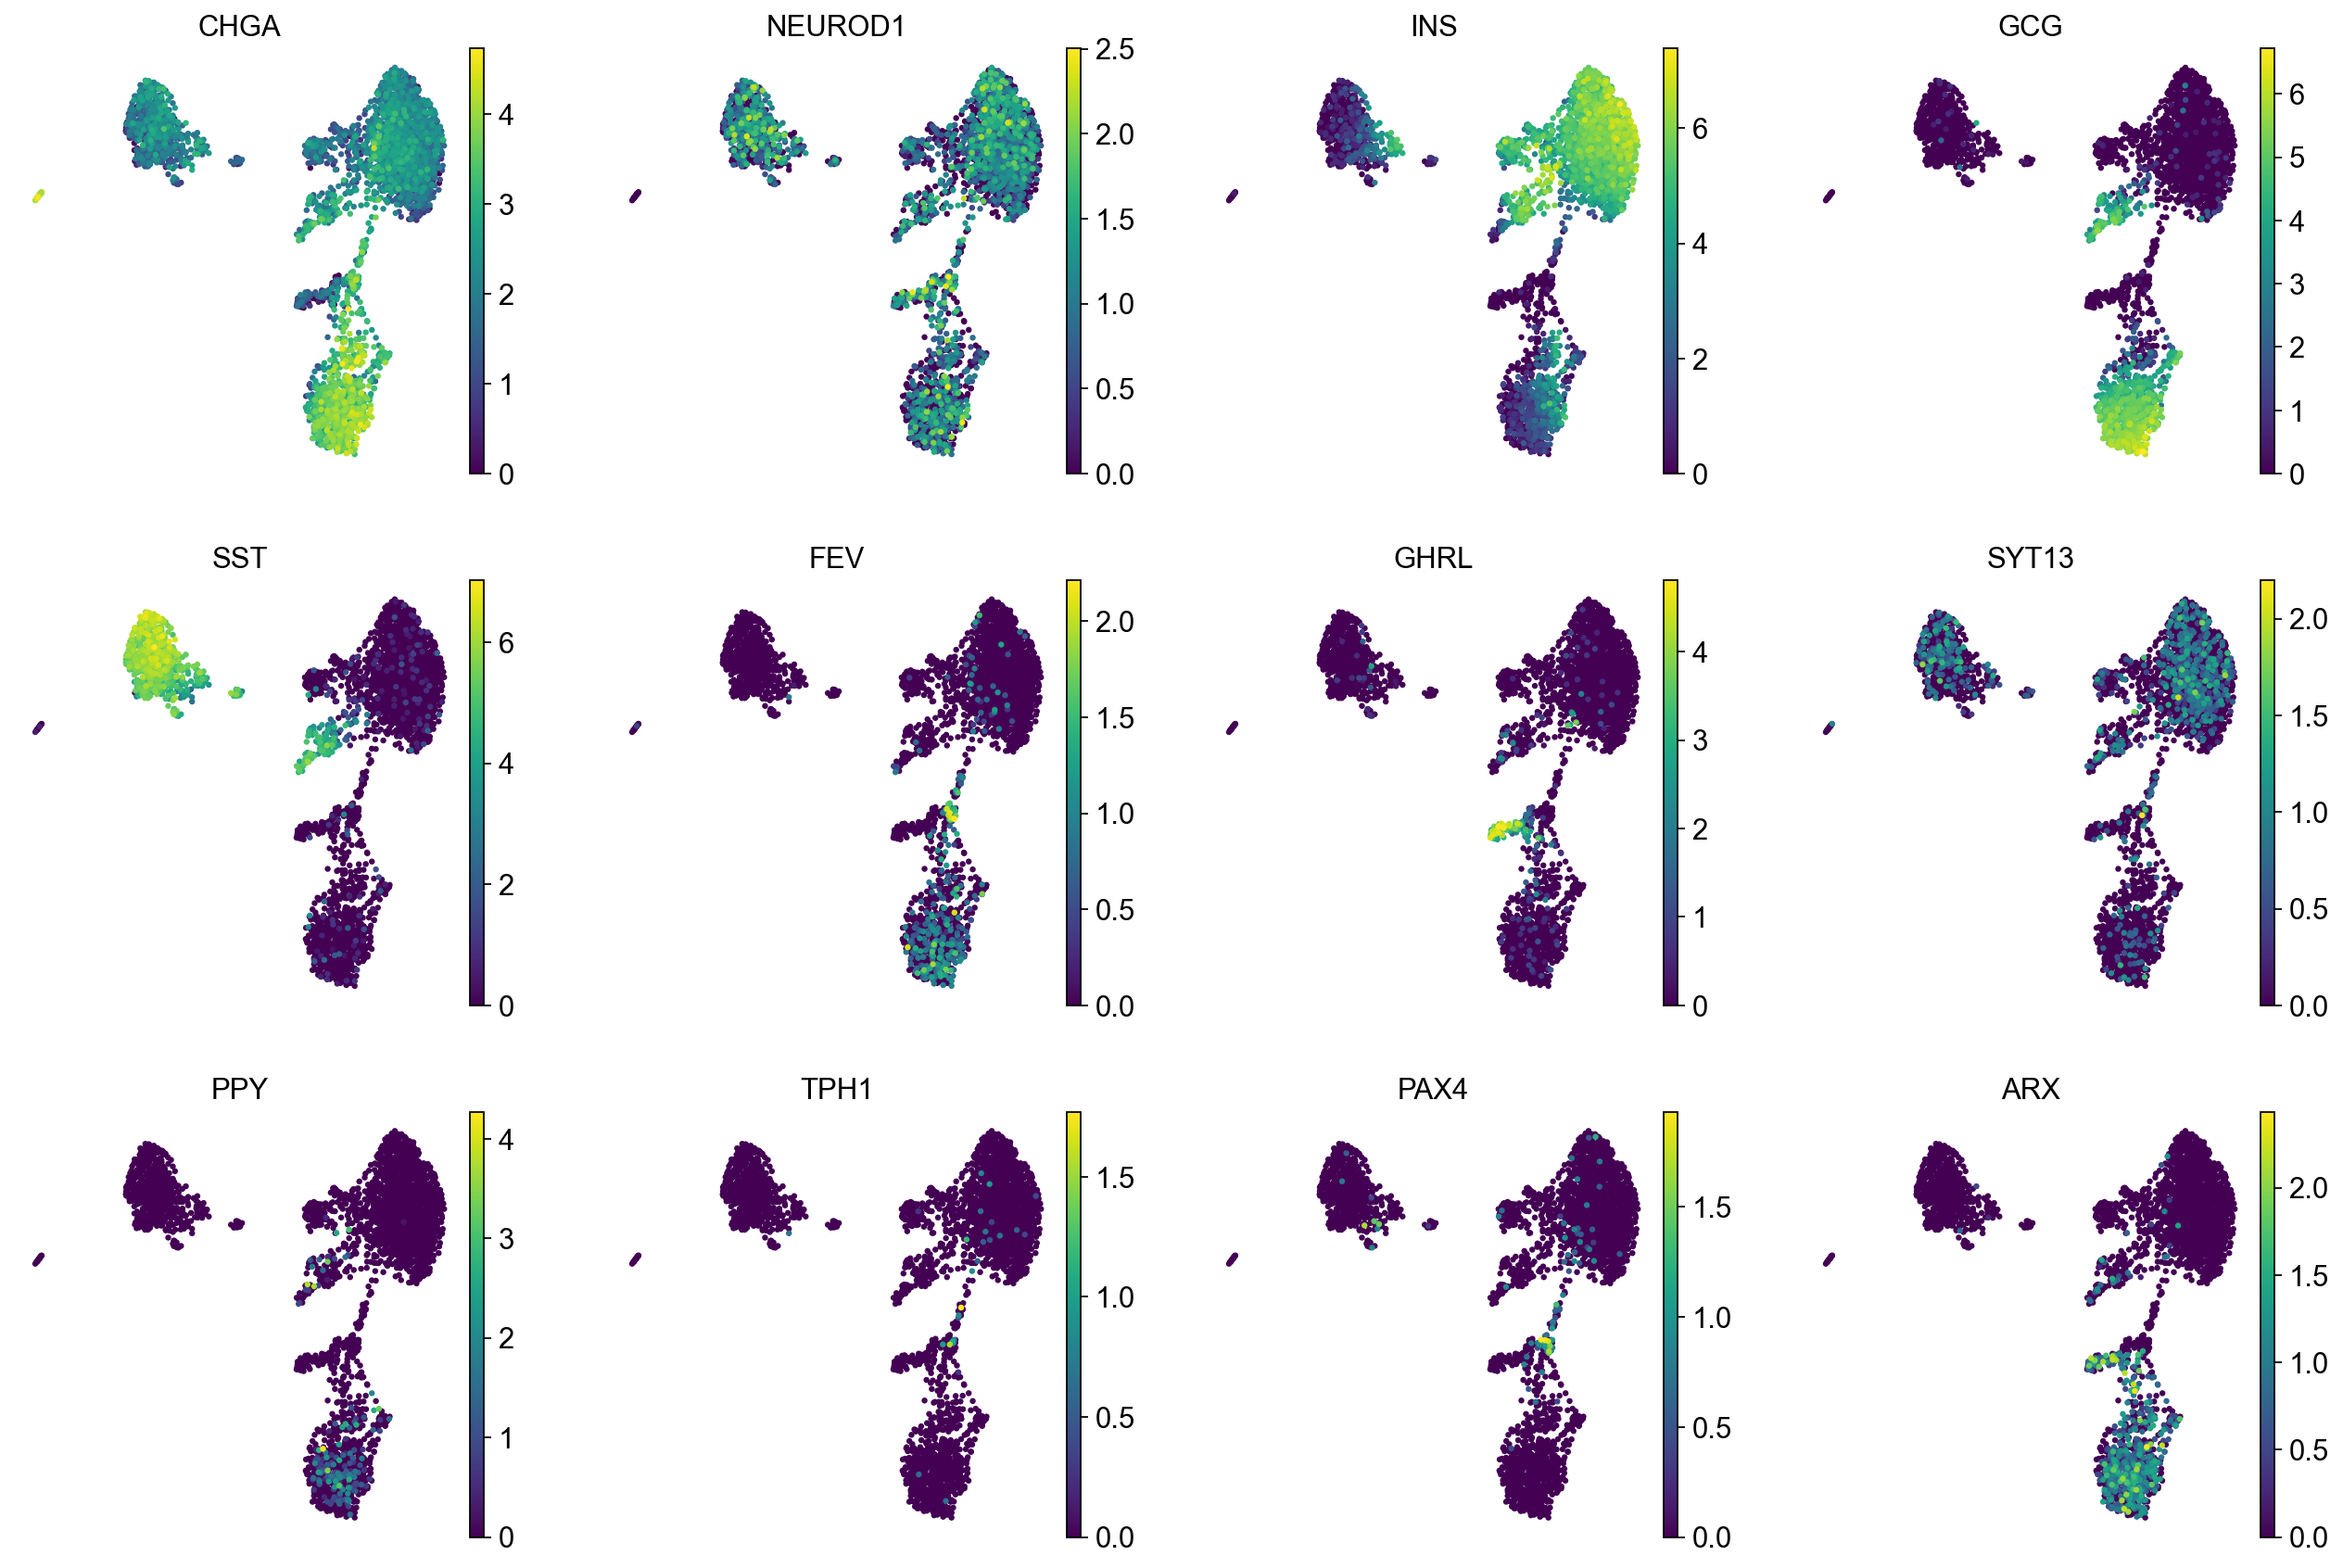

In [151]:
sc.pl.umap(sce_endo, color=['CHGA', 'NEUROD1', 'INS', 'GCG', 'SST', 'FEV', 'GHRL', 'SYT13', 'PPY', 'TPH1', 'PAX4', 'ARX'])

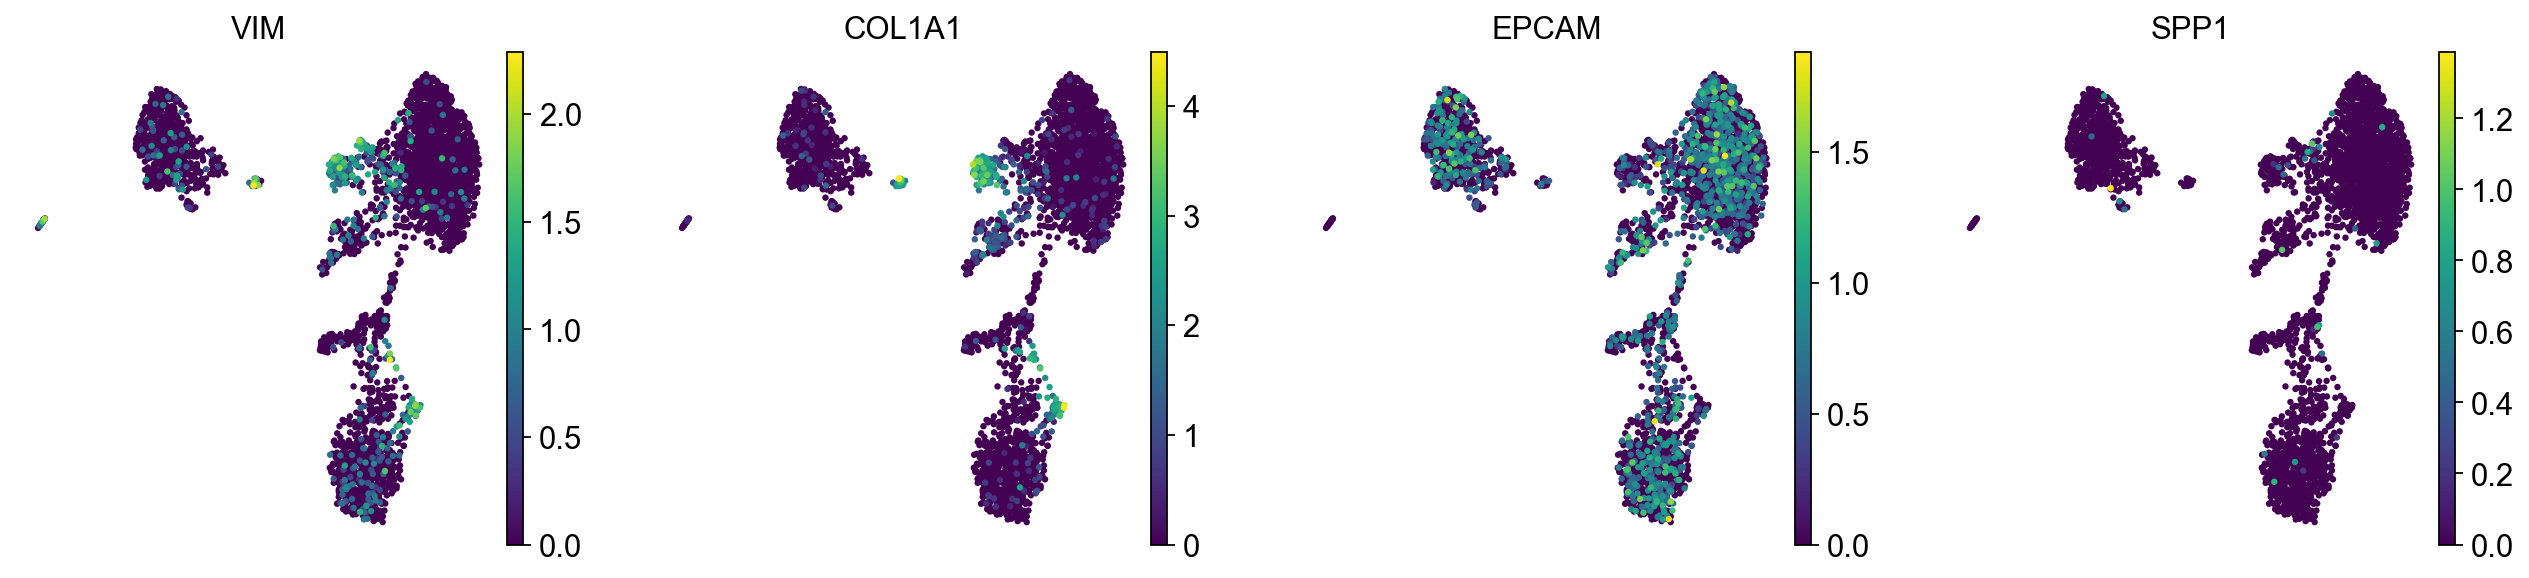

In [168]:
sc.pl.umap(sce_endo, color=['VIM', 'COL1A1', 'EPCAM', 'SPP1'])

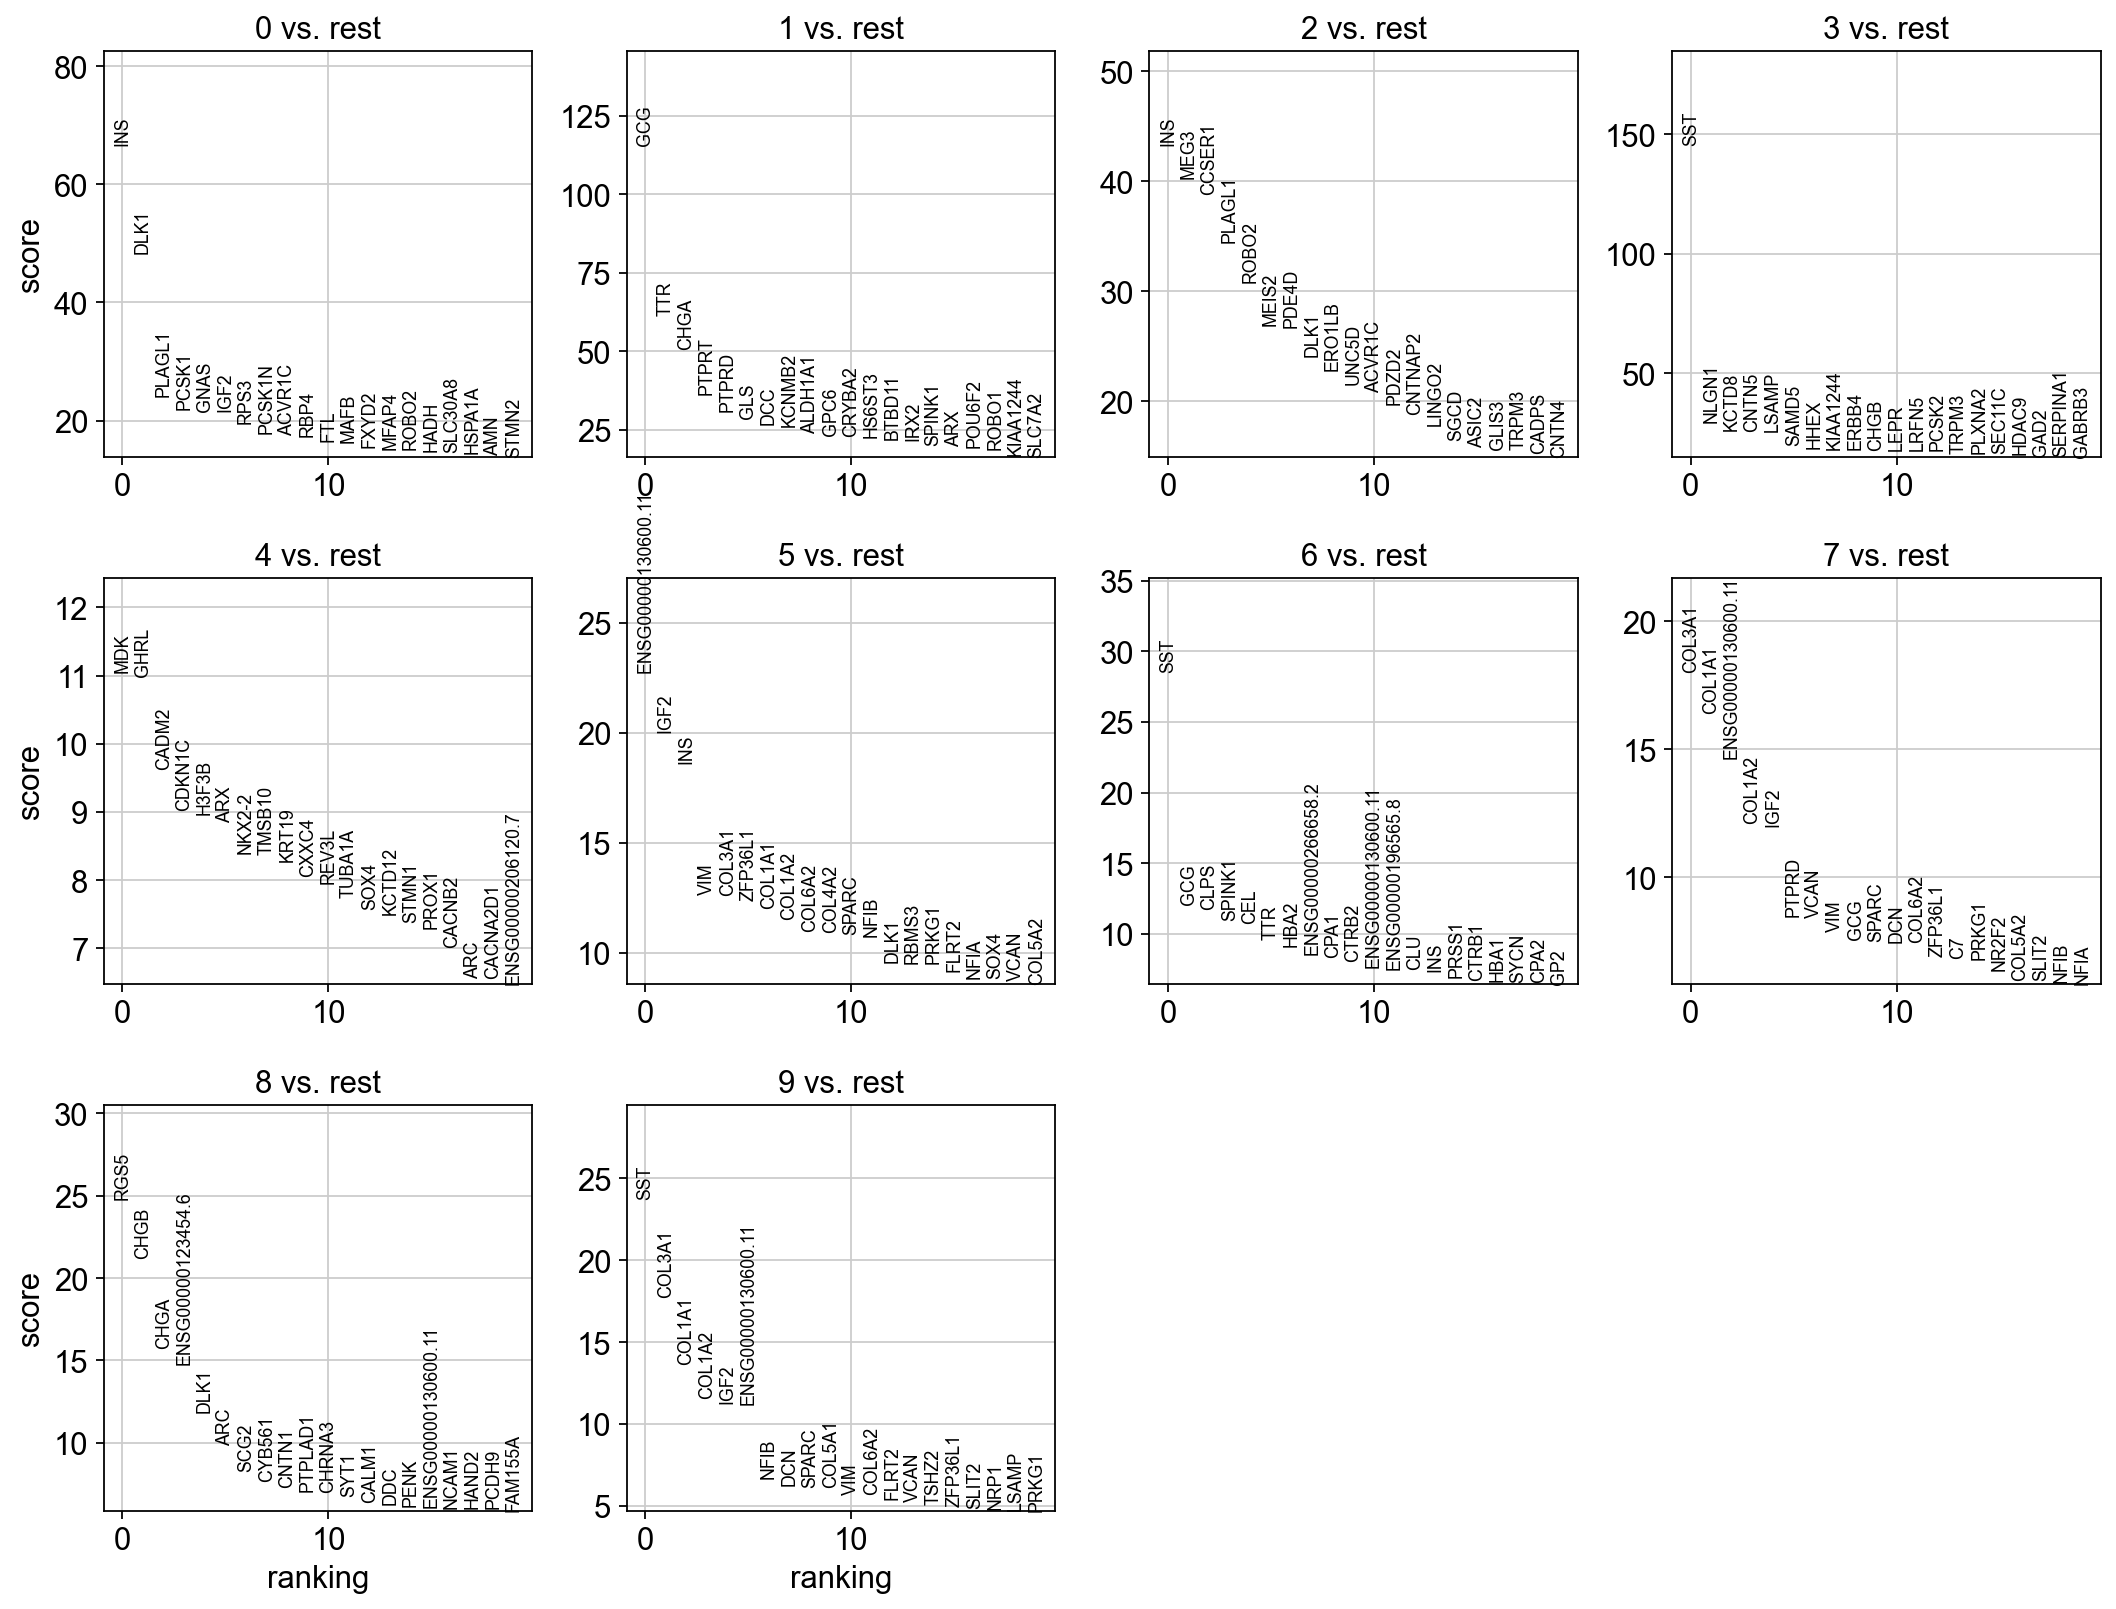

In [163]:
sc.tl.rank_genes_groups(sce_endo, groupby='louvain', method='t-test')
sc.pl.rank_genes_groups(sce_endo, sharey=False)

In [145]:
sc.tl.louvain(sce_endo)

In [160]:
sc.tl.louvain(sce_endo, restrict_to=('louvain', ['4']), key_added='louvain_r', resolution=1)

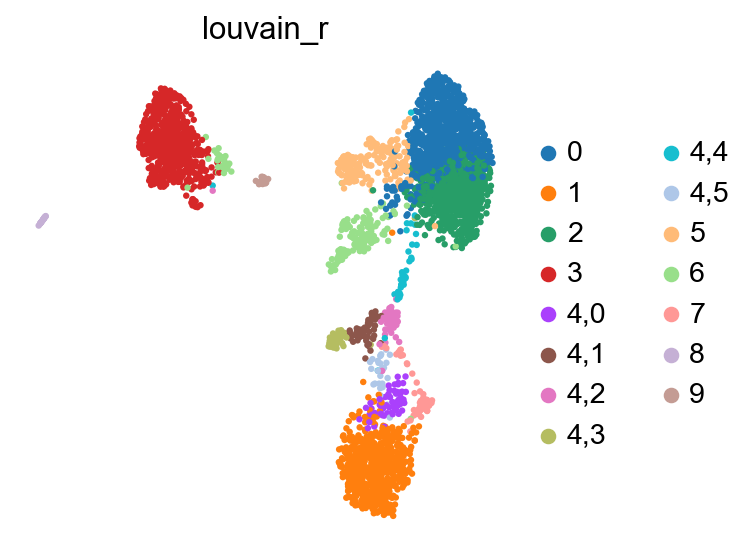

In [161]:
sc.pl.umap(sce_endo, color='louvain_r', )

In [170]:
map_names = {}
for c in sce_endo.obs['louvain_r'].cat.categories:
    if c in ['0', '2']:
        map_names[c] = 'beta'
    elif c in ['4,4']:
        map_names[c] = 'beta precursor'
    elif c in ['1']:
        map_names[c] = 'alpha'
    elif c in ['4,0', '4,5']:
        map_names[c] = 'alpha precurso'
    elif c in ['4,1', '4,3']:
        map_names[c] = 'epsilon'
    elif c in ['3']:
        map_names[c] = 'delta'
    elif c in ['4,2']:
        map_names[c] = 'Fev+ precursor'
    elif c in ['4,1', '4,3']:
        map_names[c] = 'epsilon'
    elif c in ['6']:
        map_names[c] = 'poly'
    elif c in ['7', '5', '9']:
        map_names[c] = 'endo-mesenchym.'
    elif c in ['8']:
        map_names[c] = 'endo-?'

sce_endo.obs['louvain_anno_broad']=sce_endo.obs['louvain_r']
sce_endo.obs['louvain_anno_broad']=sce_endo.obs['louvain_anno_broad'].map(map_names).astype('category')

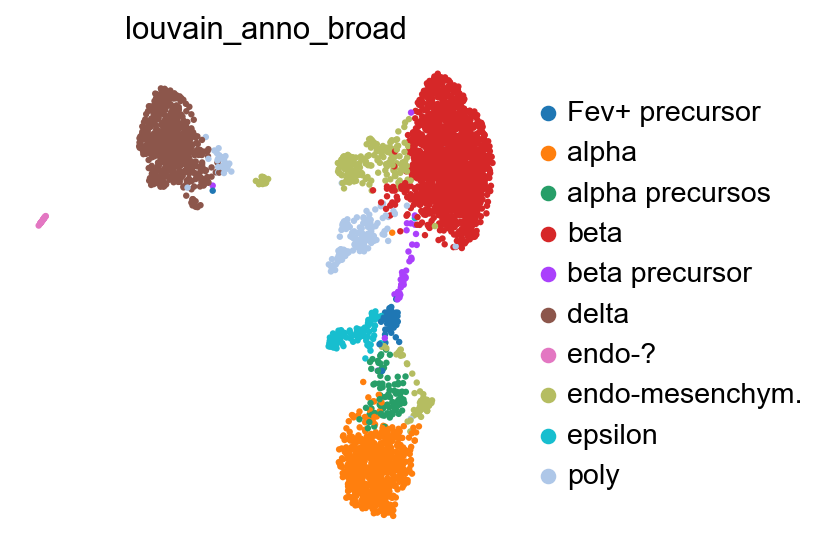

In [171]:
sc.pl.umap(sce_endo, color='louvain_anno_broad')

In [172]:
sce_endo.obs.louvain_anno_broad.cat.categories

Index(['Fev+ precursor', 'alpha', 'alpha precursos', 'beta', 'beta precursor',
       'delta', 'endo-?', 'endo-mesenchym.', 'epsilon', 'poly'],
      dtype='object')

In [173]:
sce_endo_filt = sce_endo[sce_endo.obs.louvain_anno_broad.isin(['Fev+ precursor', 'alpha', 'alpha precursos', 'beta', 'beta precursor', 'delta', 'epsilon'])].copy()

/Users/stritschler/code/miniconda3/envs/r_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [174]:
sc.pp.filter_genes(sce_endo_filt, min_cells=10)
sc.pp.highly_variable_genes(sce_endo_filt, n_top_genes=4000)
sc.pp.pca(sce_endo_filt)
sc.pp.neighbors(sce_endo_filt)
sc.tl.umap(sce_endo_filt)

/Users/stritschler/code/miniconda3/envs/r_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [10]:
sce_endo_filt.obs.louvain_anno_broad.cat.reorder_categories(['Fev+ precursor', 'alpha precursor', 'alpha', 'beta precursor', 'beta', 'delta', 'epsilon'], inplace=True)

In [11]:
sce_endo_filt.uns['louvain_anno_broad_colors'] = ['#fec44f', '#a1d99b', '#279e68',  '#fc9272', '#d62728', '#1f77b4', '#e377c2', '#bdbdbd']

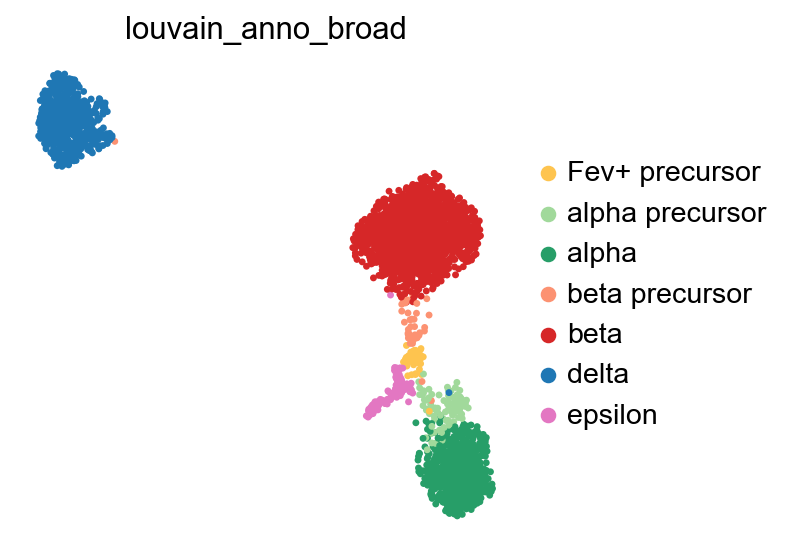

In [12]:
sc.set_figure_params(frameon=False)
sc.pl.umap(sce_endo_filt, color='louvain_anno_broad')

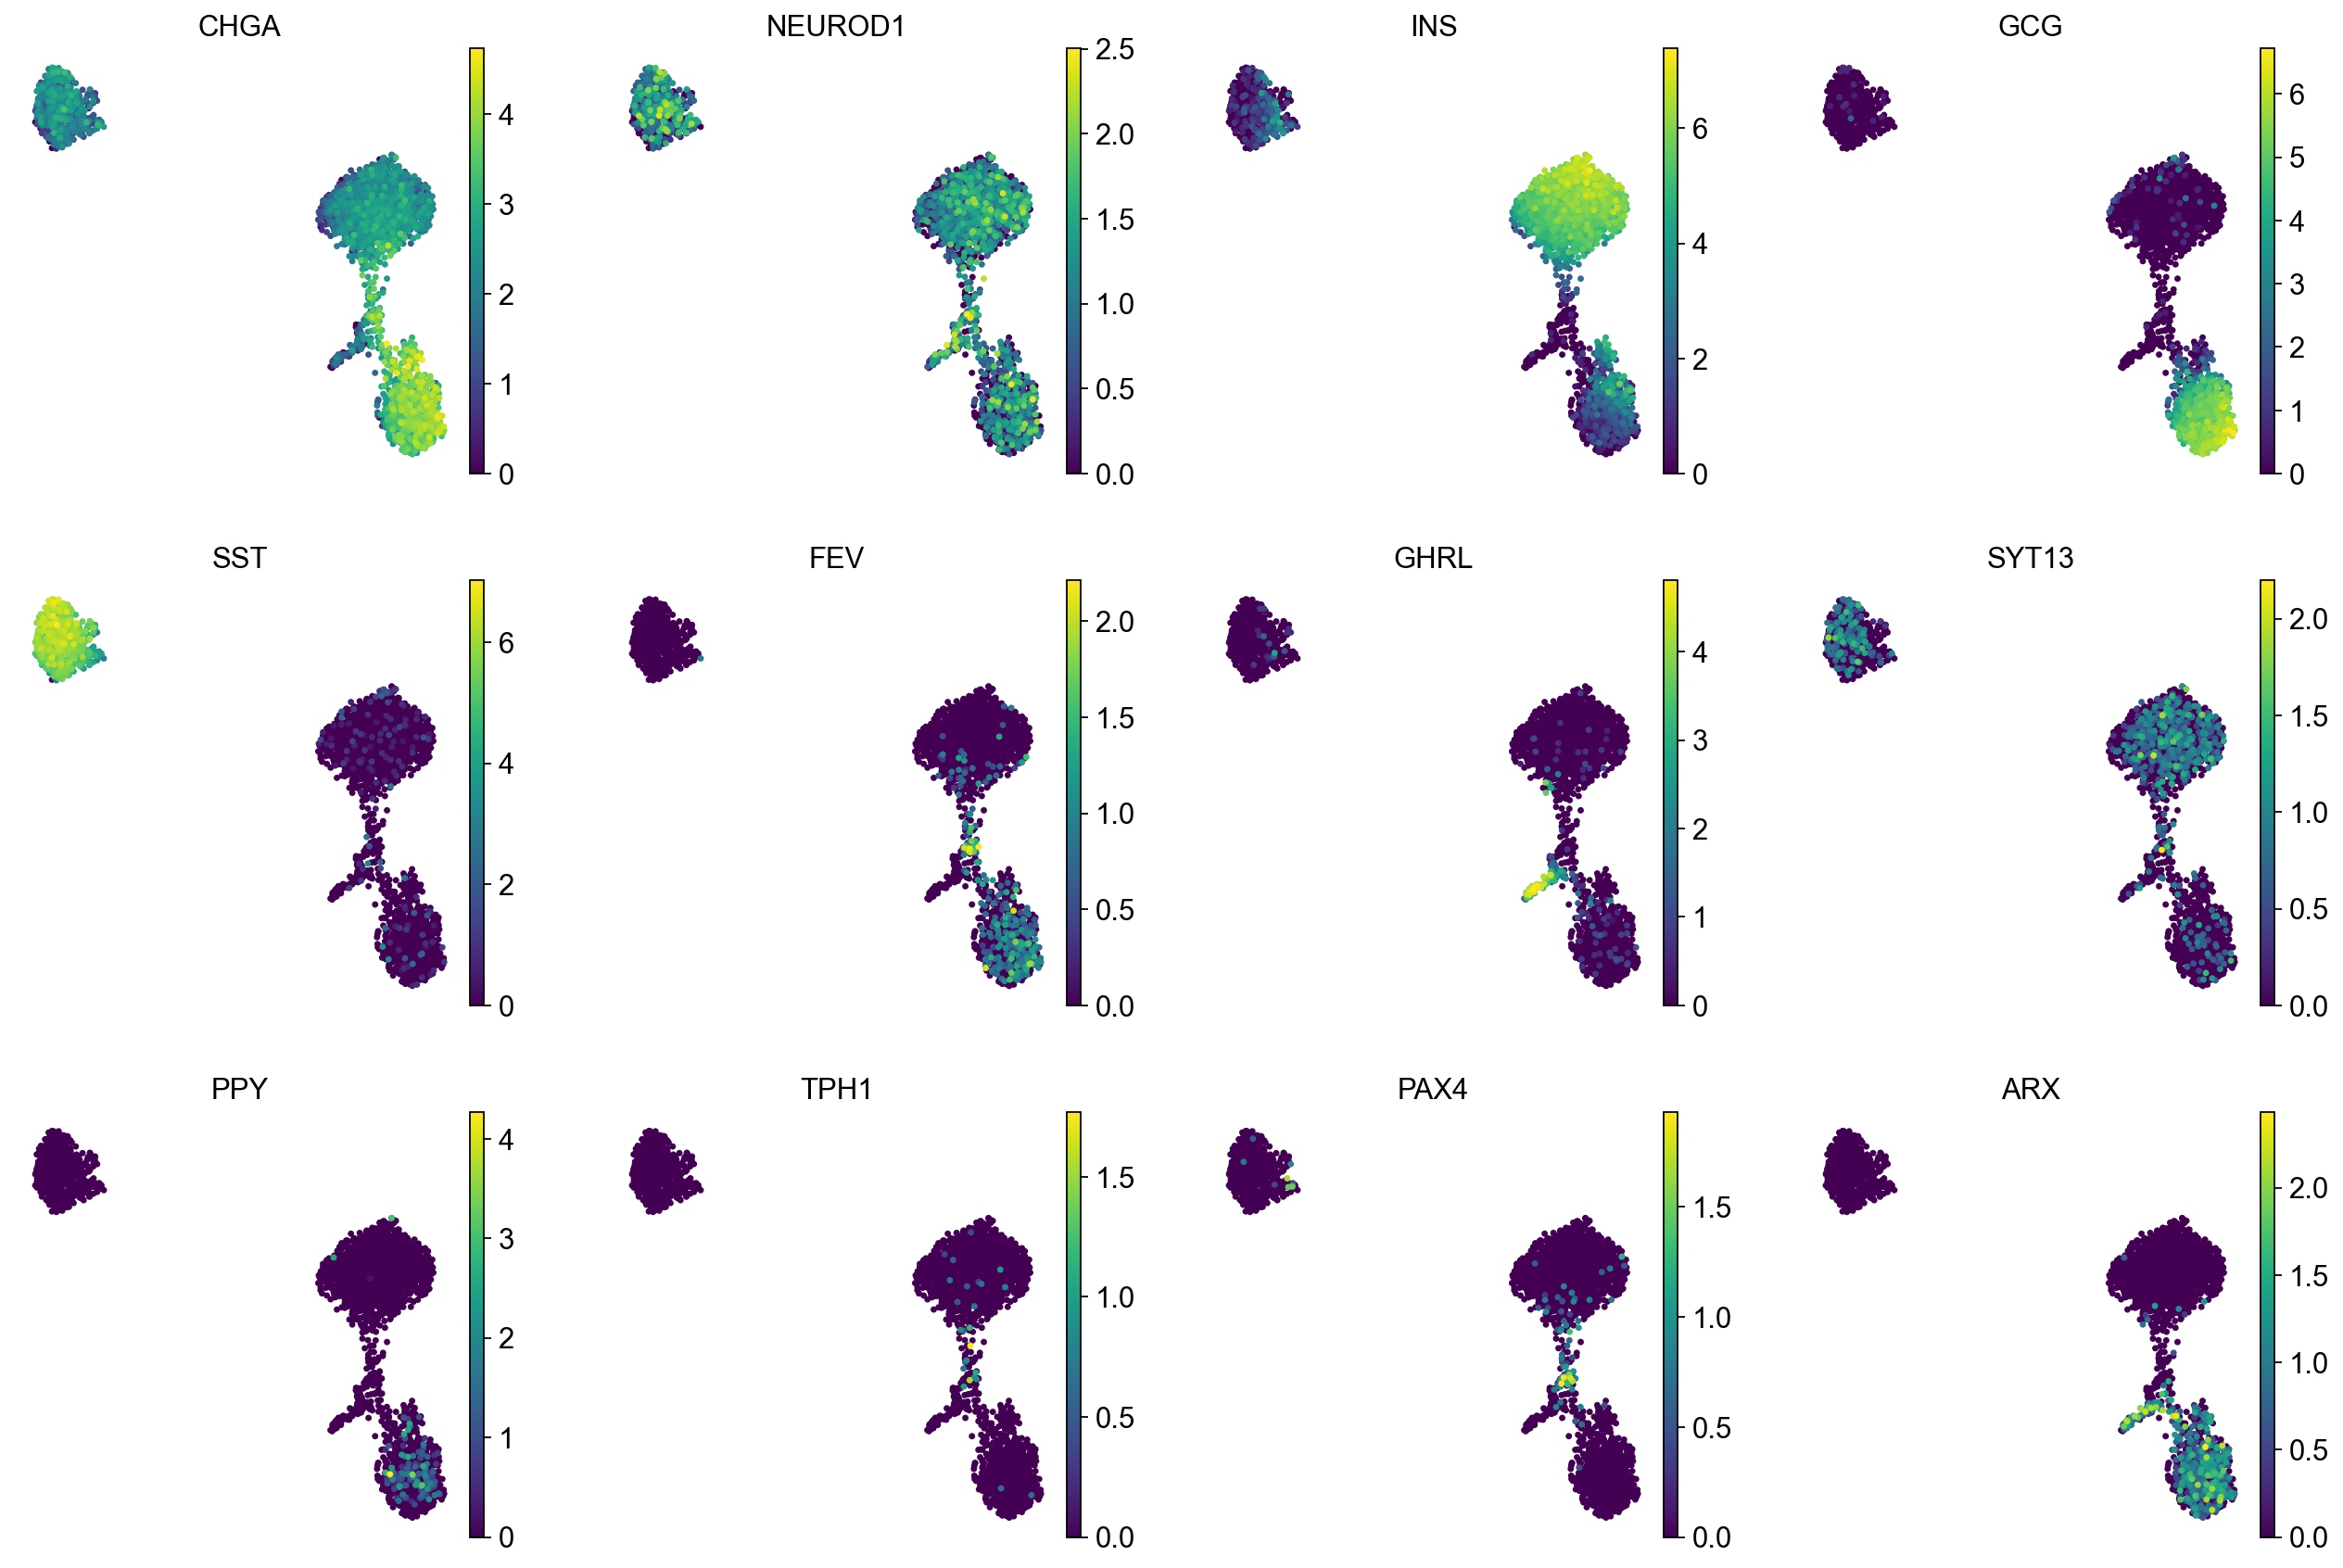

In [176]:
sc.pl.umap(sce_endo_filt, color=['CHGA', 'NEUROD1', 'INS', 'GCG', 'SST', 'FEV', 'GHRL', 'SYT13', 'PPY', 'TPH1', 'PAX4', 'ARX'])

In [177]:
sce_endo_filt.write('./data/cao_fetal_endo.h5ad')